In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Instantiate a quantum register holding two qubits
# and a classical register holding two classical bits
q_reg = QuantumRegister(size=2, name="q")
c_reg = ClassicalRegister(size=2, name="c")

In [2]:
# Instantiate a circuit containing the bits and qubits
circuit = QuantumCircuit(q_reg, c_reg)


# Set the first qubit in a superposition of ∣0⟩ and ∣1⟩
# For this, use the Hadamard gate
circuit.h(q_reg[0])

# Then use the control-not gate, with the first qubit as the control
# and the sencond qubit as the target. This should entangle the qubits
# in a state ( ∣00⟩ + ∣11⟩ ) / sqrt(2)
circuit.cx(control_qubit=q_reg[0], target_qubit=q_reg[1])

# To ensure that the qubits are entangled, add a measurement for both qubits
# Store the measurement results in the classical bits in the c_reg
circuit.measure_all(add_bits=False)

# Visualize the circuit
circuit.draw()


┌───┐      ░ ┌─┐   
q_0: ┤ H ├──■───░─┤M├───
     └───┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ─────┤ X ├─░──╫─┤M├
          └───┘ ░  ║ └╥┘
c: 2/══════════════╩══╩═
                   0  1

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler import generate_preset_pass_manager
from dotenv import load_dotenv
import os


# To run and measure the circuit, instantiate a service that runs the circuit
# In order to instantiate a service, create an account at https://quantum.ibm.com/
# and use your IBM token (find it at /account)
load_dotenv()
token = os.getenv("IBM_TOKEN")
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

# First, simmulate running the circuit, to make sure everything is ok.
# Use a backend specifically for simulating (there's a lot of them)
backend = FakeAlmadenV2()

# Use the transpiler to optimize the circuit for the backend, creating the circuit
# that obeys the Instruction Set Architectrue (ISA)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

In [7]:
# Visualize the original and ISA cirucit to see the difference
print(f"ORIGINAL CIRCUIT: \n{circuit}\n")
print(f"ISA CIRCUIT:\n{isa_circuit.draw(idle_wires=False)}") # don't present wires that aren't used

ORIGINAL CIRCUIT: 
     ┌───┐      ░ ┌─┐   
q_0: ┤ H ├──■───░─┤M├───
     └───┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ─────┤ X ├─░──╫─┤M├
          └───┘ ░  ║ └╥┘
c: 2/══════════════╩══╩═
                   0  1 

ISA CIRCUIT:
         ┌─────────┐      ░ ┌─┐   
q_0 -> 0 ┤ U2(0,π) ├──■───░─┤M├───
         └─────────┘┌─┴─┐ ░ └╥┘┌─┐
q_1 -> 1 ───────────┤ X ├─░──╫─┤M├
                    └───┘ ░  ║ └╥┘
    c: 2/════════════════════╩══╩═
                             0  1 


Hadamard state bloch representation: [1. 0. 0.]
U2 state bloch representation: [1. 0. 0.]
Arrow3D((0, 0)->(0, 0))
Arrow3D((0, 0)->(0, 0))
Arrow3D((0, 0)->(0, 0))


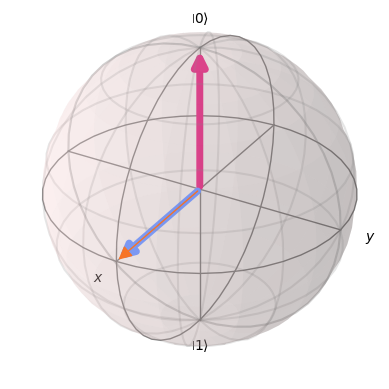

In [ ]:
# The two circuits differ only in that the Hadamard gate is presented as a U2(0,pi) gate
# A quick read through the docs (https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.U2Gate)
# shows that the U2 gate "plugs" in the values of 0 and pi in the matrix representation
# It would make sense that the U2 and hadamard gates are equal, let's confirm by visualizing

import numpy as np
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Arrow3D

import matplotlib.pyplot as plt
%matplotlib inline

def qubit_to_bloch(qubit_state):
    """
    Convert a 2D qubit state [alpha, beta] to its 3D Bloch sphere representation (x, y, z).
    """
    alpha, beta = qubit_state  # Extract components
    x = 2 * np.real(np.conj(alpha) * beta)
    y = 2 * np.imag(np.conj(alpha) * beta)
    z = np.abs(alpha)**2 - np.abs(beta)**2
    return np.array([x,y,z])
 
# following the linked doc
def construct_u2_matrix(phi_arg, lambda_arg):
    return np.array([
        [1, -np.exp(lambda_arg * 1j)],
        [np.exp(1j*phi_arg), np.exp(1j*(phi_arg+lambda_arg))]
    ]) * 1/np.sqrt(2)

zero_state_qubit = np.array([1,0])
hadamard_matrix = np.array([[1,1],[1,-1]]) * 1/np.sqrt(2)
u2_matrix = construct_u2_matrix(phi_arg=0, lambda_arg=np.pi)

hadamard_state = hadamard_matrix @ zero_state_qubit
u2_matrix_state = u2_matrix @ zero_state_qubit

bloch_zero = qubit_to_bloch(zero_state_qubit)
bloch_hadamard = qubit_to_bloch(hadamard_state)
bloch_u2 = qubit_to_bloch(u2_matrix_state)

print(f"Hadamard state bloch representation: {bloch_hadamard}")
print(f"U2 state bloch representation: {bloch_u2}")
assert bloch_hadamard.all() == bloch_u2.all()

sv = [bloch_zero, bloch_hadamard, bloch_u2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot Bloch vector
plot_bloch_vector(sv, ax=ax)

# Modify arrows in the Bloch sphere
i = 0
for obj in ax.get_children():
    if isinstance(obj, Arrow3D):
        print(obj)
        i+=1
        if i == 3:
            #obj.set_alpha(0.3)  # Set transparency (alpha)
            obj.set_linewidth(1)  # Make arrow thicker

plt.show()

# The hadamard and u2 states should overlap, the plot shoud effectively show only
# two arrows, as the third one i


In [ ]:
from qiskit_ibm_runtime import SamplerV2
 
# There are two main ways to get the results from the circuit
# If measuring the qubits at the end of the circuit, 
# a sampler is used to get the results
sampler = SamplerV2(backend)
job = sampler.run([isa_circuit], shots=5000) # shots = no of iterations
print(job.status())

JobStatus.RUNNING


In [ ]:
# In this example, there is only one circuit in the job, so only one circuit-level 
# element in the results, get it by index [0]
circuit_res = job.result()[0]

# In the circuit results, there are named results and the naming convention changes (in 03.2025.)
# There are two ways to approach extracting results
# 1. inspect the results, see the name(s) and hardcode them
print(circuit_res.data.items()) # The BitArray is named 'c' in this case
print(f"Results: {circuit_res.data.c.get_counts()}") # access the attribute 'c' in data


# 2. programatically extract the name(s) and access the BitArrays
bit_arrays = iter(circuit_res.data.items())
named_bit_array = next(bit_arrays)
name = named_bit_array[0]
results = named_bit_array[1].get_counts()
print(f"\nname of bit_array: '{name}'\nResults: {results}")


dict_items([('c', BitArray(<shape=(), num_shots=5000, num_bits=2>))])
Results: {'11': 2517, '00': 2483}

name of bit_array: 'c'
Results: {'11': 2517, '00': 2483}


In [ ]:
print(f"The {100*results.get('11',0)/5000}% of cases measured 11")
print(f"The {100*results.get('00',0)/5000}% of cases measured 00")
print(f"The {100*results.get('01',0)/5000}% of cases measured 11")
print(f"The {100*results.get('10',0)/5000}% of cases measured 00")

# The results show  that there are only two states present
# around 50% of the results are measured from ∣00⟩ and around 50% from ∣11⟩
# There are 0 occurences of ∣01⟩ and ∣10⟩, showing that this basic
# entanglement is successful, as both bits show the same value

The 50.34% of cases measured 11
The 49.66% of cases measured 00
The 0.0% of cases measured 11
The 0.0% of cases measured 00


In [ ]:
# Then, later on, try the circuit on a real quantum computer
backend_real = service.least_busy(simulator=False, operational=True)